# Prediction of motor failure based on sensor readings.
### Task:  
- Predict motor failure on the next cycle or propose an alternative formulation of the problem of predicting it and provide solution.  
- It is given that the maximum cycle of the motor is the last cycle before the breakdown.  
- It is necessary to offer options for using the resulting model in practice.  

### Description of the [data](https://github.com/aziart/motor-breakdown-prediction/blob/main/data.csv):  
- __id__: id of the motor
- __cycle__: work cycle
- __p00-p20__: sensor readings read during operation
- __s0, s1__: settings changed at the end of each cycle  

## Libraries + Preliminary Data Overview
In this section, we import the libraries that I will work with throughout the process. Previously, we want to understand what data we are working with, understand the quality of the data (the presence of missing and categorical variables), see how the variables correlate with each other, visualize for the overall picture, and see the basic statistical metrics for variables

### Libraries

In [1]:
# import libraries (+settings) to view the data
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(filename = 'logs.log',
                    level = logging.DEBUG,
                    format = '%(asctime)s %(levelname)s %(message)s',
                    filemode = 'w')

import pandas as pd
pd.set_option('display.max_columns', 30)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import Machine Learning libraries (+metrics and split method)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import numpy as np
import pandas as pd

### Data Overview

In [2]:
# pulled the data into the specified variable
source = "data.csv"
all_data = pd.read_csv(source, sep = ',')

In [3]:
# data
all_data.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


In [4]:
# check what data we are working with.
# it is fundamentally important at the beginning of the task to understand whether there are categorical data or missing values

print("Number of NaN\'s is:\n".format(all_data.isnull().sum().sum()))
print("The data types are as following: \n{}".format(all_data.dtypes))

Number of NaN's is:

The data types are as following: 
id         int64
cycle      int64
p00      float64
p01      float64
p02      float64
p03      float64
p04      float64
p05      float64
p06      float64
p07      float64
p08        int64
p09        int64
p10        int64
p11      float64
p12      float64
p13      float64
p14      float64
p15      float64
p16      float64
p17      float64
p18      float64
p19      float64
p20      float64
s1       float64
s2       float64
dtype: object


As we can observe, all features are numerical. This simplifies things a lot.

In [5]:
# feature statistics
description = all_data.describe().round(4).T
description

,count,mean,std,min,25%,50%,75%,max
id,16138.0,40.7079,23.3954,1.0000,20.0000,42.0000,61.0000,80.0000
cycle,16138.0,105.5481,65.9153,1.0000,51.0000,101.0000,153.0000,362.0000
p00,16138.0,518.6700,0.0000,518.6700,518.6700,518.6700,518.6700,518.6700
p01,16138.0,1.3000,0.0000,1.3000,1.3000,1.3000,1.3000,1.3000
p02,16138.0,47.5443,0.2674,46.8600,47.3500,47.5200,47.7100,48.5300
p03,16138.0,521.4054,0.7383,518.6900,520.9400,521.4600,521.9400,523.3800
p04,16138.0,2388.0967,0.0726,2387.8800,2388.0400,2388.0900,2388.1400,2388.5600
p05,16138.0,8143.9335,19.7313,8099.9400,8132.8300,8140.7500,8148.8175,8293.7200
p06,16138.0,8.4426,0.0375,8.3249,8.4153,8.4398,8.4660,8.5848
p07,16138.0,0.0300,0.0000,0.0300,0.0300,0.0300,0.0300,0.0300


__Correlation Matrices__

In [6]:
# correlation >= 0.7
correlation_matrix = all_data.corr().round(2)
correlation_matrix[correlation_matrix>=0.7]

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cycle,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p02,NaN,NaN,NaN,NaN,1.00,NaN,0.78,NaN,0.78,NaN,0.72,NaN,NaN,0.74,NaN,NaN,0.7,0.83,NaN,NaN,NaN,0.78,NaN,NaN,NaN
p03,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.76,NaN,NaN,NaN,NaN,0.81,NaN,NaN,NaN,NaN
p04,NaN,NaN,NaN,NaN,0.78,NaN,1.00,NaN,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.74,NaN,NaN,NaN,0.83,NaN,NaN,NaN
p05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN
p06,NaN,NaN,NaN,NaN,0.78,NaN,0.70,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.76,NaN,NaN,NaN,0.70,NaN,NaN,NaN
p07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# correlation >= 0.5
correlation_matrix[correlation_matrix>=0.5]

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cycle,NaN,1.00,NaN,NaN,0.64,NaN,NaN,NaN,0.59,NaN,0.57,NaN,NaN,0.55,NaN,NaN,0.54,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p02,NaN,0.64,NaN,NaN,1.00,NaN,0.78,NaN,0.78,NaN,0.72,NaN,NaN,0.74,NaN,NaN,0.70,0.83,NaN,NaN,NaN,0.78,NaN,NaN,NaN
p03,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,0.76,NaN,NaN,NaN,NaN,0.81,NaN,NaN,NaN,NaN
p04,NaN,NaN,NaN,NaN,0.78,NaN,1.00,NaN,0.70,NaN,0.63,NaN,NaN,0.66,NaN,NaN,0.60,0.74,NaN,NaN,NaN,0.83,NaN,NaN,NaN
p05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97,NaN,NaN
p06,NaN,0.59,NaN,NaN,0.78,NaN,0.70,NaN,1.00,NaN,0.67,NaN,NaN,0.68,NaN,NaN,0.64,0.76,NaN,NaN,NaN,0.70,NaN,NaN,NaN
p07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# create dataframe with last cycle indices
selected_idx = all_data.groupby("id").apply(lambda all_data: all_data['cycle'].idxmax())
selected_rows = all_data.loc[selected_idx, :]
last_cycles = selected_rows[['id', 'cycle']]
last_cycles

,id,cycle
191,1,192
478,2,287
657,3,179
846,4,189
1115,5,269
...,...,...
15368,76,210
15522,77,154
15753,78,231
15952,79,199


The minimum number of cycle, after which motor has broken:
128
Some statistics on cycles after motor breaks:
count     80.000000
mean     201.725000
std       41.353057
min      128.000000
25%      173.500000
50%      195.500000
75%      215.250000
max      362.000000
Name: cycle, dtype: float64


(0.0, 30.0)

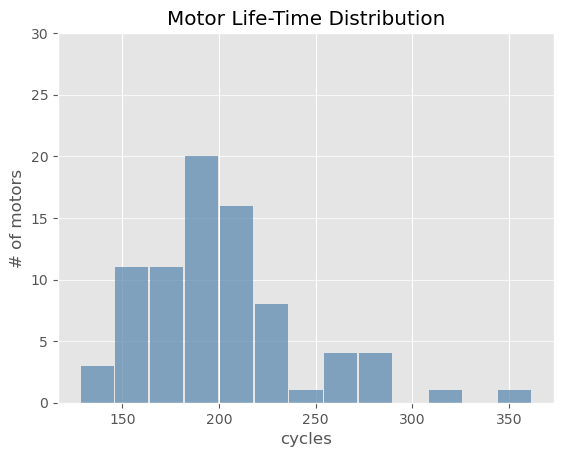

In [9]:
min_cycle = last_cycles['cycle'].min()
print("The minimum number of cycle, after which motor has broken:\n{}".format(min_cycle))
print("Some statistics on cycles after motor breaks:\n{}".format(last_cycles['cycle'].describe()))


# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=last_cycles['cycle'], bins='auto',
                            color='#5584AC',
                            alpha=0.7, rwidth=0.95)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('cycles')
plt.ylabel('# of motors')
plt.title('Motor Life-Time Distribution')
maxfreq = n.max()
plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

#### First insights

- The absolute correlation of some variables immediately catches the eye. The standard deviation for each of these columns is zero. Obviously, variables with the same value for every observation and most probably useless
- There are also variables that correlate not absolutely, but nevertheless strongly. We should reduce the number of variables to a minimum, but at the same time not lose those that can strengthen our machine learning model
- Most of all, we were interested in how the settings correlate with the rest of the variables. This did not give anything that could be useful in solving the problem

#### What about cycles

This exercise have been done in order to think about the target event during the search for a solution
- According to life-cycle of given 80 motors, the minimum breakage cycle is 128th
- According to the right-skewed distribution (on histogram), we see, on average, by the 200th cycle, the motors break down.  

It is difficult to draw any unusual conclusions, except that it is obvious that motors have the property of depreciation as they are used.


### Visualization

- In this section we visualize some the variables together (all motors in one diagram in order to see if there's any common pattern visually).
Most of them are removed from the final version so as not to interfere.

__Example of "bad" (useless) feature__

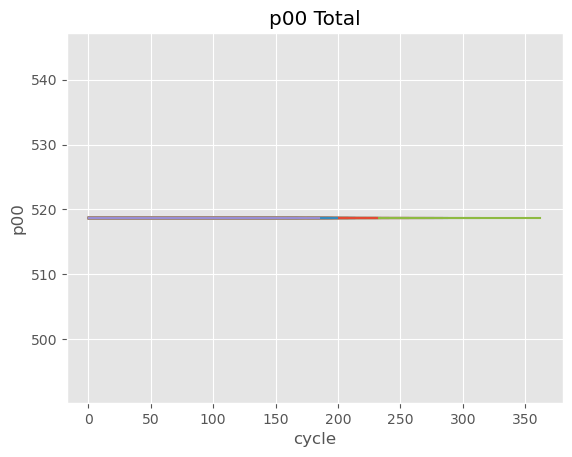

In [10]:
# p00 values for each cycle
for i in range(1,all_data['id'].max() + 1):
    plt.plot(all_data[all_data['id']==i]['cycle'],all_data[all_data['id']==i]['p00'])
    plt.grid()
    plt.xlabel('cycle')
    plt.ylabel('p00')
    plt.title('p00 Total')
plt.show()

__Example of feature with strong shift__

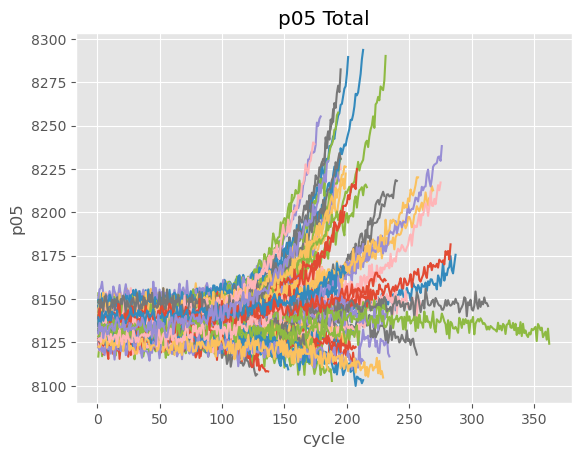

In [11]:
# p05 values for each cycle (all motors)
for i in range(1,all_data['id'].max() + 1):
    plt.plot(all_data[all_data['id']==i]['cycle'],all_data[all_data['id']==i]['p05'])
    plt.grid()
    plt.xlabel('cycle')
    plt.ylabel('p05')
    plt.title('p05 Total')
plt.show()

__Example of how "bad" visualization can be useful__

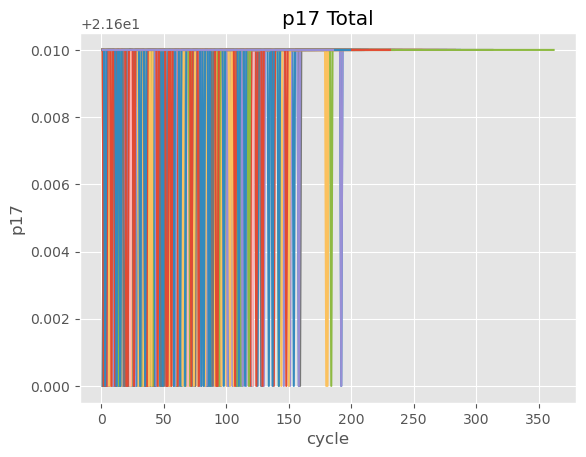

In [12]:
# p17 values for each cycle
for i in range(1,all_data['id'].max() + 1):
    plt.plot(all_data[all_data['id']==i]['cycle'],all_data[all_data['id']==i]['p17'])
    plt.grid()
    plt.xlabel('cycle')
    plt.ylabel('p17')
    plt.title('p17 Total')
plt.show()

At first it may seem that this "all-in-one" plot doesn't make sense, but as we can see, at some point of every motor lifecycle, value of indicated feature stops hitting zero-value. In future model training it could be helpful if we define different targets ("against each other") for different periods for each motor when creating TRAIN DATASET. For instance, almost last ten cycles for motor_1 can have target "1" and other ten cycles from period where feature still hits zero-value can have target "0". It may not be the best way of training model in such way in terms of "businessivity" and strength of model in correct classifying, but this feature is good example of predictors that may seem useless at first, but which still can have good potential in increasing number of approaches we can choose from.

#### Conclusion:
There are "good" features (after approximately half of motor life-time, most of them strongly tend (shift) to the values defined for each variable). But like "p00" there also are absolutely useless ones. So in order to have stable model, we need to drop them off.

### Actions and approach to solving the problem itself (building a model)

- Based on what has been done above, we remove unnecessary variables;
- Let's start with the simplest way of solving problem and check whether it is possible to predict breakage on the remaining variables on the next cycle by taking the penultimate cycle as target = 0, and the last target = 1 - if this does not give us anything, then we will build a model on time series

In [13]:
all_data

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,397,2388,100,644.00,38.39,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,396,2388,100,643.81,38.34,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,397,2388,100,643.49,38.34,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,397,2388,100,643.83,38.53,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


In [14]:
# drop unnecessary features
all_data = all_data.drop(["p00", "p01", "p07", "p09", "p10", "p16"], axis=1)

In [15]:
# dataset after dropping unnecessary features
all_data

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2
0,1,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8218.63,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,48.41,520.06,2388.12,8221.91,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,48.04,519.67,2388.21,8217.46,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,48.04,519.72,2388.20,8228.65,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


#### Creating a list with motors and their cycles

Let's exclude the id of the motors while creating list of arrays(cycles of each motor) - they will already be splitted in the list

In [16]:
# creating list of arrays(cycles of each motor)
prev_item = None
collection = []

motor = []

for item in all_data.values:
    if prev_item is not None:
        motor.append(prev_item)
    
    if item[1] == 1 and prev_item is not None:
        collection.append(np.array(motor)[:,1:])
        motor = []
    prev_item = item
    
motor.append(prev_item)
collection.append(np.array(motor)[:,1:])

In [17]:
print(collection[0][0])         # 1st engine first cycle
print(collection[79][184])      # 79th engine last cycle

[ 1.00000e+00  4.74700e+01  5.21660e+02  2.38802e+03  8.13862e+03
  8.41950e+00  3.92000e+02  6.41820e+02  3.90600e+01  2.34190e+01
  1.58970e+03  1.40060e+03  2.16100e+01  5.54360e+02  2.38806e+03
  9.04619e+03 -7.00000e-04 -4.00000e-04]
[1.85000e+02 4.80500e+01 5.20000e+02 2.38818e+03 8.22973e+03 8.52500e+00
 3.97000e+02 6.43880e+02 3.83500e+01 2.30323e+01 1.60638e+03 1.42141e+03
 2.16100e+01 5.51550e+02 2.38822e+03 9.17057e+03 1.50000e-03 0.00000e+00]


In [18]:
print(all_data.values[200])     # 200th row of dataframe

[ 2.00000e+00  9.00000e+00  4.71400e+01  5.22400e+02  2.38798e+03
  8.14529e+03  8.38680e+00  3.90000e+02  6.41980e+02  3.90600e+01
  2.34875e+01  1.58199e+03  1.39501e+03  2.16000e+01  5.54690e+02
  2.38802e+03  9.05167e+03  1.70000e-03 -4.00000e-04]


In [19]:
length_of_collection = len(collection)                                      # number of motors in collection
print("{} is a number of motors in list".format(length_of_collection))      # number of motors in collection
print("The shape of motor 1 is {}".format(collection[0].shape))             # motor 1: number of cycles (and number of features)
print("The shape of motor 2 is {}".format(collection[1].shape))             # motor 2: number of cycles (and number of features)

80 is a number of motors in list
The shape of motor 1 is (192, 18)
The shape of motor 2 is (287, 18)


__The next step is to check whether any one feature can predict a breakdown well. We will take last cycle and the penultimate one and define targets for those observations as 1 and 0, respectively. We can use decision tree for this one:__

In [20]:
for i in range(18):
    X = []
    Y = []
    for motor in collection:
        X.append([motor[-1][i]])
        X.append([motor[-2][i]])
        Y.append(1)
        Y.append(0)
    X = np.array(X)
    
    a = []
    for _ in range(100):
        clf = DecisionTreeClassifier(random_state=0)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
        clf.fit(X_train, Y_train)
        a.append(accuracy_score(clf.predict(X_test), Y_test))
    print("{} feature predicting accuracy is {}".format(i, np.mean(a).round(2)))
 

0 feature predicting accuracy is 0.49
1 feature predicting accuracy is 0.44
2 feature predicting accuracy is 0.46
3 feature predicting accuracy is 0.54
4 feature predicting accuracy is 0.5
5 feature predicting accuracy is 0.48
6 feature predicting accuracy is 0.44
7 feature predicting accuracy is 0.46
8 feature predicting accuracy is 0.49
9 feature predicting accuracy is 0.49
10 feature predicting accuracy is 0.53
11 feature predicting accuracy is 0.54
12 feature predicting accuracy is 0.41
13 feature predicting accuracy is 0.45
14 feature predicting accuracy is 0.44
15 feature predicting accuracy is 0.42
16 feature predicting accuracy is 0.6
17 feature predicting accuracy is 0.56


__Let's check whether it is possible to predict breakdown using only last cycle and the penultimate one. We will use decision tree again to check if there's huge difference in those last cycles of motors__

In [21]:
# Creating arrays with the penultimate cycle and the one before it for each motor
X = []
Y = []
for motor in collection:
    X.append(motor[-1])
    X.append(motor[-2])
    Y.append(1)
    Y.append(0)
X = np.array(X)

# shape of created matrix (dataframe)
print(X.shape)

# fit the model
clf = DecisionTreeClassifier(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
clf.fit(X_train, Y_train)

# check accuracy
temp = 0
for xx, yy in zip(clf.predict(X_test), Y_test):
    if xx==yy:
        temp += 1
    else:
        continue
print("Accuracy score is: {}".format(temp/16))
del temp

# or use library metric
# print("Accuracy score is: {}".format(accuracy_score(clf.predict(X_test), Y_test)))

(160, 18)
Accuracy score is: 0.625


__This did not give us any satisfying results, as it would in iris classification problem, for instance. The exercise was done for the reason that the task itself required to predict motor failure on next cycle and the only possible way to do this was to take last cycles and try to contrast them with different target events. So, let's try to find alternative approach to solve the problem.__

__As we know from what we've done so far, the minimum breakdown cycle is 128th, so we can try training model taking 127th cycle with 0 target for each motor and last cycle (before breakage) with target=1.__

In [22]:
# dataset
X = []
Y = []
for motor in collection:
    X.append(motor[-1])
    X.append(motor[127])
    Y.append(1)
    Y.append(0)
X = np.array(X)

# split: train/validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

a = []

# average accuracy
for _ in range(1000):
    clf = DecisionTreeClassifier(random_state=0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
    clf.fit(X_train, Y_train)
    a.append(accuracy_score(clf.predict(X_test), Y_test))
print("Accuracy is %{}".format(100 * np.mean(a)))

Accuracy is %98.46249999999999


__It may seem that we can stop here, but the thing is that this model is most likely too skewed. We compare two types of cycles which were taken from too different periods of motor life-time, which means that, if we use this model in production, it will give us lots of false-positives. This will force us to replace motors long before they become unusable. If our task is to diagnose motors in advance and keep them in excellent condition, then this solution will suit us, but if the motors cannot be used in production after repair, then our task is to predict a breakdown much closer to it. Otherwise, whole process will become too expensive.__

__Looks like time series approach would fit perfectly for this problem. Let's create dataset with last 20 cycles data and divide them as if last 10 are failures and 10 that come before them as if there was no breakdown. If it works, we will have solution which predicts breakdown in next 10 cycles__

In [23]:
D      = 10 + 1
offset = 10 + 1

X = []
y = []
for motor in collection:
    X.append(np.array([[motor[-i]] for i in range(1, D)]))
    X.append(np.array([[motor[-i - offset]] for i in range(1, D)]))
    y.append(1)
    y.append(0)
X = np.array(X)

X = X.reshape(160, -1)

In [24]:
class ModelRunner:
    def __init__(self):
        self.model = None
        self.params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'colsample_bytree': 0.6,
            'subsample': 0.6,
            'subsample_freq': 3,
            'verbose': -1,
            'silent': True
        }
        
    def _find_best_params(self, X_train, y_train):
        # define search parameters
        param_grid = {
            'num_leaves': [15, 31, 63],
            'learning_rate': [0.01, 0.05, 0.1],
            'colsample_bytree': [0.6, 0.8, 0.9],
            'subsample': [0.6, 0.8, 0.9],
            'subsample_freq': [3, 5, 7]
        }
        
        # Create an instance of the model and run GridSearchCV
        gbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc')
        grid_search = GridSearchCV(gbm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=-100)
        grid_search.fit(X_train, y_train)
        
        # return the best parameters
        return grid_search.best_params_
    
    def fit(self, X, y):
        # divide the data into training and test samples
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        # find best parameters
        best_params = self._find_best_params(X_train, y_train)
        
        # update parameters of model
        self.params.update(best_params)
        
        # train model
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test)
        self.model = lgb.train(self.params, train_data, num_boost_round=1000, 
                               valid_sets=[valid_data], early_stopping_rounds=50, 
                               verbose_eval=False)
        
    def predict(self, X):
        # predict values
        return np.round(self.model.predict(X))
        
    def evaluate(self, X, y):
        # predict values
        y_pred = self.predict(X)
        
        # evaluate the quality of the model (accuracy and ROC-AUC)
        accuracy = accuracy_score(y, y_pred)
        roc_auc = roc_auc_score(y, self.model.predict(X))
        
        #print metrics
        print('Accuracy: %.4f' % accuracy)
        print('ROC-AUC: %.4f' % roc_auc)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
clf = ModelRunner()
clf.fit(X_train, y_train)
clf.evaluate(X_test, y_test)

Accuracy: 0.8750
ROC-AUC: 0.9766


### 

### "Make it simple = stable" step

__Let's check with what accuracy each feature will be able to predict target value, if we combine and define last 10 cycles as "1" (failure) and 10 ones before them as "0"__

In [26]:
for feat in range(18):
    X = []
    Y = []
    for motor in collection:
        X.append(np.array([motor[-i][feat] for i in range(1, 11)]))
        X.append(np.array([motor[-i - 11][feat] for i in range(1, 11)]))
        Y.append(1)
        Y.append(0)
    X = np.array(X)

    a = []
    for _ in range(100):
        clf = DecisionTreeClassifier(random_state=0)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
        clf.fit(X_train, Y_train)
        a.append(accuracy_score(clf.predict(X_test), Y_test))
    print("Feature {} can predict with accuracy {}".format(feat, np.mean(a).round(2)))
    
"""
features_dict = {
"cycle": 0,
"p02": 1,
"p03": 2,
"p04": 3,
"p05": 4,
"p06": 5,
"p08": 6,
"p11": 7,
"p12": 8,
"p13": 9,
"p14": 10,
"p15": 11,
"p17": 12,
"p18": 13,
"p19": 14,
"p20": 15,
"s1": 16,
"s2": 17
}
""" 

Feature 0 can predict with accuracy 0.65
Feature 1 can predict with accuracy 0.81
Feature 2 can predict with accuracy 0.66
Feature 3 can predict with accuracy 0.6
Feature 4 can predict with accuracy 0.53
Feature 5 can predict with accuracy 0.74
Feature 6 can predict with accuracy 0.67
Feature 7 can predict with accuracy 0.73
Feature 8 can predict with accuracy 0.78
Feature 9 can predict with accuracy 0.75
Feature 10 can predict with accuracy 0.7
Feature 11 can predict with accuracy 0.81
Feature 12 can predict with accuracy 0.4
Feature 13 can predict with accuracy 0.69
Feature 14 can predict with accuracy 0.57
Feature 15 can predict with accuracy 0.48
Feature 16 can predict with accuracy 0.51
Feature 17 can predict with accuracy 0.52


'\nfeatures_dict = {\n"cycle": 0,\n"p02": 1,\n"p03": 2,\n"p04": 3,\n"p05": 4,\n"p06": 5,\n"p08": 6,\n"p11": 7,\n"p12": 8,\n"p13": 9,\n"p14": 10,\n"p15": 11,\n"p17": 12,\n"p18": 13,\n"p19": 14,\n"p20": 15,\n"s1": 16,\n"s2": 17\n}\n'

__As we can see p02 is the best one in predicting target. Now, let's check how i'th feature can predict j'th one, so we could minimize number of features (out of all 18 features) by taking one more feature that is not correlated with p02 and has some information value.__

In [27]:
logging.info('Feature-feature prediction errors:')

for i in range(18):
    logging.info("FEATURE #{}".format(i))
    for j in range(18):
        if i == j:
            continue
        X = []
        Y = []
        for motor in collection:
            for t in motor[128:]:
                X.append([t[i]])
                Y.append(t[j])

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
        clf = DecisionTreeRegressor(random_state=0)
        clf.fit(X_train, Y_train)
        
        score = np.mean(clf.predict(X_test) - np.array(Y_test))
        logging.info("{}'th feature's mean error on {}'th feature is {}".format(i, j, score.round(2)))

__Take p02 and p05 and build model__

In [28]:
D      = 10 + 1
offset = 10 + 1

X = []
Y = []
for motor in collection:
    X.append(np.array([[motor[-i][1], motor[-i - 1][4]] for i in range(1, D)]))
    X.append(np.array([[motor[-i - offset][1], motor[-i - offset][4]] for i in range(1, D)]))
    Y.append(1)
    Y.append(0)
X = np.array(X)

X = X.reshape(160, X.shape[-1] * X.shape[-2])

a = []
for _ in range(100):
    clf = DecisionTreeClassifier(random_state=0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
    clf.fit(X_train, Y_train)
    a.append(accuracy_score(clf.predict(X_test), Y_test))
print("The Decision Tree Classifier accuracy is %{}".format(100 * np.mean(a).round(2)))

a = []
for _ in range(100):
    clf = RandomForestClassifier(random_state=0, n_estimators=100)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
    clf.fit(X_train, Y_train)
    a.append(accuracy_score(clf.predict(X_test), Y_test))
print("The Random Forest Classifier accuracy is %{}".format(100 * np.mean(a).round(2)))

The Decision Tree Classifier accuracy is %85.0
The Random Forest Classifier accuracy is %92.0


### Conclusion
So, our task was to predict motor failure on the next cycle or propose an alternative formulation of the problem of predicting it and provide solution. It turned out that with the data available to us, we cannot predict a motor failure on the next cycle. Alternative way is using the time series approach, in which we have obtained a fairly simple model which predicts a breakdown in the next 10 cycles, having the data of the previous 10.